In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, losses, Input

## Problem Description

This project uses deep learning to classify pathology scans based on if they have indicators of cancer in them. The data comes from the Histopathologic Cancer Detection competition on Kaggle: https://www.kaggle.com/c/histopathologic-cancer-detection. While the competition allows a range of deep learning models, we will use convolutional neural networks (CNN) for our analysis. We will test out a couple of variations on CNNs.

## Data Description & Exploratory Data Analysis

The inputs for modeling are TIF image files in the test and train directories. The sample submission file indicates that we pull the image ID from file names and add an associated 0 or 1 classification label indicating if the center region of an image contains at least one pixel of tumor tissue. The train_labels CSV has training labels matched with file IDs.

In [2]:
in_dir = '/kaggle/input/histopathologic-cancer-detection'
out_dir = '/kaggle/working'

train_dir = f'{in_dir}/train'
test_dir = f'{in_dir}/test'

df_sample_submission = pd.read_csv(f'{in_dir}/sample_submission.csv')
df_train_labels = pd.read_csv(f'{in_dir}/train_labels.csv')
train_filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)

In [3]:
n_train = len(train_filenames)
n_test = len(test_filenames)
total_samples = n_train+n_test

print(f'Number of train samples: {n_train:,} -- {n_train/total_samples:.3f} of all the samples')
print(f'Number of test samples: {n_test:,} -- {n_test/total_samples:.3f} of all the samples')

Number of train samples: 220,025 -- 0.793 of all the samples
Number of test samples: 57,458 -- 0.207 of all the samples


In [4]:
print(df_train_labels.shape)
df_train_labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We have about 220,000 train samples and 57,500 test samples, about an 80-20 split. Let's take a look at some sample images to see what we're working with.

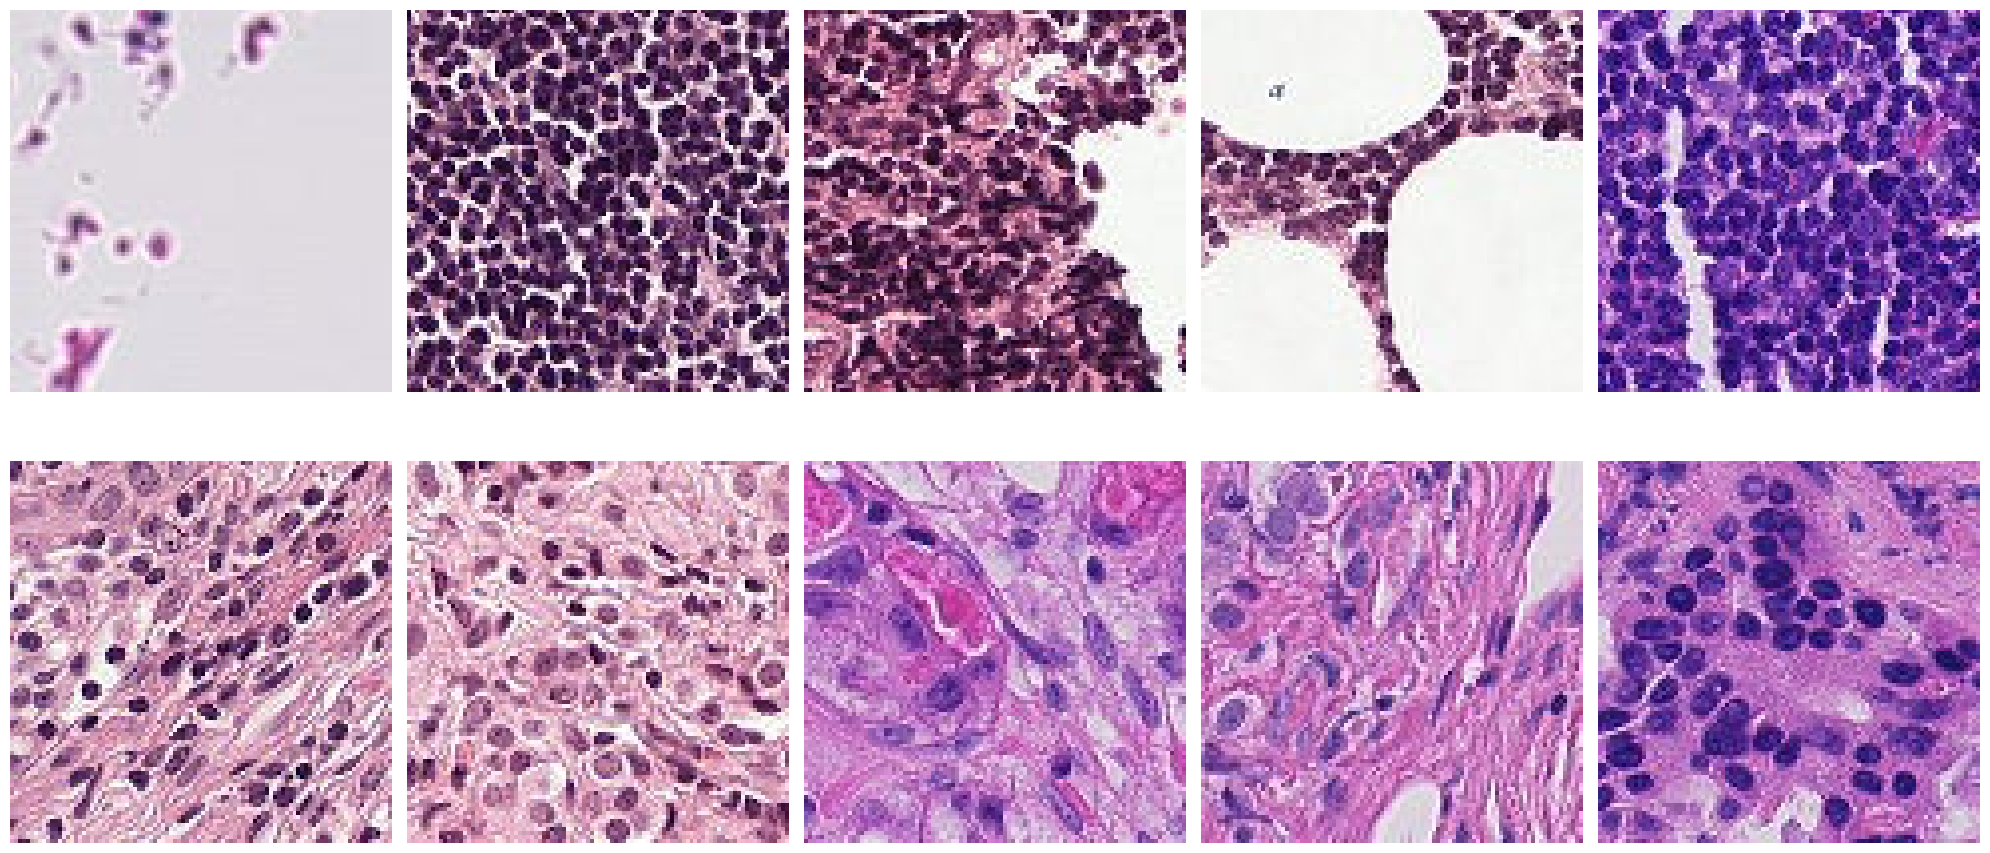

In [5]:
# Set up grid with 2 rows and 5 columns
fig, axes = plt.subplots(
    2
    , 5
    , figsize=(20,10)
)

for i, img in enumerate([
    # Unpacking the lists directly instead of creating an intermediate combined list
    *df_train_labels.loc[df_train_labels['label'] == 0, 'id'].sample(5).tolist() 
    ,*df_train_labels.loc[df_train_labels['label'] == 1, 'id'].sample(5).tolist()
]):
    axes[
        0 if i < 5 else 1 # Row 0 or 1
        , i if i < 5 else i-5 # Col 0 - 5
    # Display TIF image with matplotlib
    ].imshow(Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{img}.tif'))

# Turn axis labels and grids off
for ax in axes.ravel():
    ax.set_axis_off()
    
fig.tight_layout()

In [6]:
print(f'The images have pixel size of: ' \
      f'{Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[0,0]}.tif").size} and ' \
      f'{Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[0,0]}.tif").getbands()} channels'
)

The images have pixel size of: (96, 96) and ('R', 'G', 'B') channels


The top row has images with labels indicating no cancer in the center region of the image. The bottom row has images labeled as having cancer. I'm not able to parse these out visually. Fortunately, we will use the CNNs below to classify for us.

We also see that the size of the image is 96x96 pixels and three color channels. Below we will confirm that all images have the same size.

Let's see if we have balanced class representation.

Percentage of 0 labels: 0.595
Percentage of 1 labels: 0.405



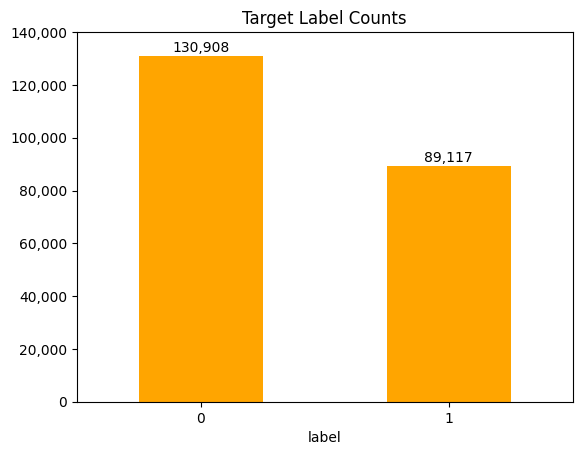

In [7]:
label_counts = df_train_labels.groupby('label').count()
zeros = label_counts.loc[0].values[0]
ones = label_counts.loc[1].values[0]

print(f'Percentage of 0 labels: {zeros/(zeros+ones):.3f}')
print(f'Percentage of 1 labels: {ones/(zeros+ones):.3f}')
print()

ax = label_counts.plot(
    kind='bar'
    , rot=0
    , legend=False
    , color='orange'
    , title='Target Label Counts'
);

ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=1
);

# matplotlib throws a warning if you do not set the axis label values before then 
# reformatting the labels, so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

We have a 60-40 split for 0-1 label counts. This is not too big of a skew towards the 0s. We will keep an eye out as we dig into further EDA and then modeling in case any other signs of problematic class imbalance pop up, but, for now, I am comfortable moving forward with this split.

Next we will check for missing or invalid values.

In [8]:
# Check nulls
print(f'Number of missing values: {df_train_labels.isnull().sum().sum()}')
print()

# Check that all IDs are a consistent length
print(f'Unique lengths of IDs: { {len(id) for id in df_train_labels["id"]} }')
print()

# Make sure no IDs show up more than once in the label CSV
print(f'Number of unique IDs: {len(df_train_labels["id"].unique()):,}')
print(f'Number of total IDs:  {df_train_labels.shape[0]:,}')
print()

# Check that no train IDs exist in one spot and not the other.We still have the file 
# extension in train_ids but not in the label df, so we strip it out for the next checks
print(f'IDs in train CSV but not in file names: {set(df_train_labels["id"]).difference(set([id[:-4] for id in train_filenames]))}')
print(f'IDs in file names but not in train CSV: {set([id[:-4] for id in train_filenames]).difference(set(df_train_labels["id"]))}')
print()

# Check that we only have 0s and 1s for labels
print(f'Unique target labels: {df_train_labels.label.unique()}')
print()

# Check image sizes -- this can take awhile, but it will tell us if we need dynamic checks
# for size during modeling or if all the files have the same pixel size. Since this takes
# so long to run, I put the output below each print statement and will comment the print
# statements out unless we need to rerun them for any reason.
#
# print(f'Unique train image sizes: ' 
#     f'{ {Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{img}").size for img in train_ids} }'
# )
#
# Output
print('Unique train image sizes: {(96, 96)}')

# print(f'Unique test image sizes: ' \
#     f'{ {Image.open(f"/kaggle/input/histopathologic-cancer-detection/test/{img}").size for img in test_ids} }'
# )
#
# Output
print('Unique test image sizes: {(96, 96)}')

Number of missing values: 0

Unique lengths of IDs: {40}

Number of unique IDs: 220,025
Number of total IDs:  220,025

IDs in train CSV but not in file names: set()
IDs in file names but not in train CSV: set()

Unique target labels: [0 1]

Unique train image sizes: {(96, 96)}
Unique test image sizes: {(96, 96)}


We have no missing values in either columns. All of the IDs are 40 characters long, there are no duplicate IDs in the train CSV, and there are no IDs in the training label CSV or in the training file names that do not exist in the other. We only have 0s and 1s for labels. All of the inputs look like they are present and valid.

The lines that are commented out at the end check that each train and test file has the same 96x96px dimensions. This is important because it means we do not need to adjust different image sizes to the same size.

Scanning the list of IDs, it does look like they may be somewhat sequential rather than fully unique such as with UUIDs. We will also check that there are no patterns of clusters of nearby IDs that all have 0s or 1s.

The next code block is what I used to explore different chunks of ID ranges. The problem is that the dataset is big enough that we see two solid lines at 0 and 1 when looking at the whole dataset at once. I then tried smaller ranges. Around a range of 500, you can see some missing spots, typically for 1s, but there does not seem to be a pattern. I ended up doing some spot checking, but I was not able to find a programmatic way to display plots with enough detail to be useful without breaking the notebook due to displaying too many plots.

I will display a sample plot and keep the main code commented out. I was unable to find any index-series patterns related to labeling.

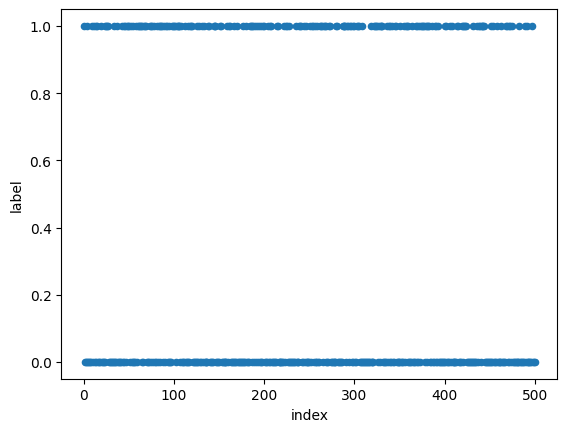

In [9]:
# for i in range(0, df_train_labels.shape[0], 500):
#     if df_train_labels.shape[0] - i < 500:
#         df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[-500:].plot(kind='scatter', x='index', y='label', use_index=True);
#     df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[i:i+500].plot(kind='scatter', x='index', y='label', use_index=True);

df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[0:500].plot(kind='scatter', x='index', y='label', use_index=True);

## Preprocessing

The EDA above did not indicate any major issues with the image data, but we do need some work to prepare the data for modeling.

First we will explore the dimensions of the images in more detail. As we saw above and again here, each image is a 96x96px color image, so they also have the three RGB channels for the color, leaving us with 96x96x3 arrays for each image.

We will need to isolate the 32x32px center of the image and will crop each image down to just the central region we need.

We will use PIL to explore an image for understanding, but we will leverage TensorFlow after for actual image manipulation.

The PIL coordinate system starts with (0,0) in the upper left. We then need to calculate the upper-left and bottom-right corners of the cropped rectangle in the center of the image by adding the correct number of horizontal and vertical pixels.

The base images have 96 pixels in each dimension. We need to remove 32 pixels from both dimensions to set aside the cropped area we are keeping. 96-32=64 pixels that we need to remove in each dimension. We then half that since the cropped area is symmetric around the center lines in each dimension. 64/2=32 pixels from each border towards the center to reach the boundary for the remaining cropped image.

This leaves us with the following corners for the 32x32px cropped area in the center
- upper left = (32, 32)
- upper right = (64, 32)
- bottom right = (64, 64)
- bottom left = (32, 64)

We will use similar logic later for cropping with TensorFlow.

Image size: (96, 96)
Image bands: ('R', 'G', 'B')
Image shape as numpy array: (96, 96, 3)

Image as numpy array: [[[251 247 246]
  [253 248 245]
  [243 238 235]
  ...
  [255 254 250]
  [242 237 233]
  [255 249 246]]

 [[237 233 232]
  [241 235 235]
  [240 235 232]
  ...
  [252 247 243]
  [240 232 229]
  [248 238 236]]

 [[247 243 242]
  [247 241 241]
  [248 242 242]
  ...
  [239 234 230]
  [244 236 233]
  [243 232 230]]

 ...

 [[206 186 198]
  [217 197 209]
  [255 238 248]
  ...
  [248 236 238]
  [246 237 238]
  [251 247 246]]

 [[244 221 237]
  [214 191 207]
  [194 172 185]
  ...
  [255 240 243]
  [252 240 242]
  [255 247 248]]

 [[244 219 238]
  [249 224 243]
  [201 178 194]
  ...
  [243 222 227]
  [253 237 240]
  [255 246 248]]]



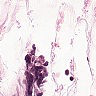

In [10]:
img = Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif')
print(f'Image size: {img.size}')
print(f'Image bands: {img.getbands()}')
print(f'Image shape as numpy array: {np.asarray(img).shape}')
print()
print(f'Image as numpy array: {np.asarray(img)}')
print()
Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif')

(32, 32)


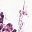

In [11]:
print(Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif').crop(
    (
        32, 32 # Upper-left corner
        , 64, 64 # Bottom-right corner
    )
).size)
Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif').crop(
    (
        32, 32 # Upper-left corner
        , 64, 64 # Bottom-right corner
    )
)

We now need a strategy for preprocessing all of the image files for modeling. The issue is that TensorFlow does not play nice with TIF images. I tried a couple of workarounds still using TensorFlow, but none of those worked. I then tried a custom pipeline that combined reading in the TIFs with PIL and doing all of the preprocessing at that point while the files were in memory, including converting those over to TensorFlow tensors and datasets, but TensorFlow kept complaining.

In the end, the solution below loops through all of the train and test images, opens them in PIL, converts them to JPGs, and then saves them in an output directory. We can then use more common TensorFlow tooling to read the files in from the directories, bypassing the less common workarounds.

To save on time, there is a line of `shutil` code commented out too that will grab the zipped output of the two conversion loops and extract that output into the same output working directory that the two loops move the converted images into. This will save time when starting a new session since you only need to unzip the JPG images instead of re-converting everything.

In [12]:
# We will use the label param to indicate if we are working with train or test
def convert_image(image_id, label=None):
    if label is not None:
        image_path = f'{train_dir}/{image_id}.tif'
    if label is None:
        image_path = f'{test_dir}/{image_id}'
        
    with Image.open(image_path) as img:
        if label is not None:
            img.save(f'{out_dir}/train/{label}/{image_id}.jpg')
        if label is None:
            img.save(f'{out_dir}/test/{image_id[:-4]}.jpg')
            
            
def convert_all_images():
    if os.path.exists(f'{out_dir}/train'):
        shutil.rmtree(f'{out_dir}/train')
    if os.path.exists(f'{out_dir}/test'):
        shutil.rmtree(f'{out_dir}/test')

    os.makedirs(f'{out_dir}/train/0')
    os.makedirs(f'{out_dir}/train/1')
    os.makedirs(f'{out_dir}/test')

    for _, row in df_train_labels.iterrows():
        convert_image(row['id'], row['label'])
    for test_img in test_ids:
        convert_image(test_img)
        
def load_images_from_zip():
    if os.path.exists(f'{out_dir}/train'):
        shutil.rmtree(f'{out_dir}/train')
    if os.path.exists(f'{out_dir}/test'):
        shutil.rmtree(f'{out_dir}/test')
        
    shutil.unpack_archive('/kaggle/input/so-convolved/_output_.zip', f'{out_dir}/')

# Uncomment (1) or (2) the first time running the notebook each session
#
# (1)
# convert_all_images()
#
# (2)
#
load_images_from_zip()


def preprocess_image(image, label=None):
    # TensorFlow differs from PIL in that it asks for the x and y coordinates for
    # the upper-left corner of the cropped boundary, but it then asks how many
    # horizontal and vertical pixels to add to that corner rather than how PIL
    # asks for the pixel coordinates directly for the bottom-right corner
    img_cropped = tf.image.crop_to_bounding_box(image, 32, 32, 32, 32)
    img_scaled = img_cropped/255.0
    
    if label is not None:
        return img_scaled, label
    if label is None:
        return img_scaled
            
        
# ds_train_combined = image_dataset_from_directory(
#     f'{out_dir}/train'
#     , image_size=(96, 96)
#     , label_mode='int'
# ).map(preprocess_image)

# ds_test = image_dataset_from_directory(
#     f'{out_dir}/test'
#     , image_size=(96, 96)
#     , label_mode=None
# ).map(preprocess_image)

ds_train, ds_val = image_dataset_from_directory(
    f'{out_dir}/train'
    , image_size=(96, 96)
    , label_mode='int'
    , seed=8675309
    , validation_split=0.2
    , subset='both'
    , verbose='true'
)
ds_train = ds_train.map(preprocess_image)
ds_val = ds_val.map(preprocess_image)

ds_test = image_dataset_from_directory(
    f'{out_dir}/test'
    , image_size=(96, 96)
    , label_mode=None
    , verbose='true'
    , shuffle=False
).map(preprocess_image)

# ds_train_shuffled = ds_train_combined.shuffle(buffer_size=10000, seed=8675309)
# train_size = int(ds_train_combined.cardinality().numpy() * 0.8)
# ds_train = ds_train_shuffled.take(train_size)
# ds_val = ds_train_shuffled.skip(train_size)

# Batching and prefetching will hopefully improve model training performance, and
# we can return here to experiment with different batch sizes as hyperparameters
# batch_size = 3000
# ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# ds_val = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Using 44005 files for validation.
Found 57458 files.


## Modeling

This project explores using CNNs to classify the images. CNNs are feed-forward neural networks that use backpropagation to adjust the weights, the weights in CNNs being the parameter values in the kernels. The core idea with CNNs is that we apply kernels or filters -- nxm rectangular windows -- that slide along different dimensions of the input images, summarizing or abstracting elements of the image. When we add multiple kernels in a layer, each kernel picks up on a different aspect or feature in the image. When we add multiple layers into the model, each successive layer picks up on higher levels of abstraction, combining features found in previous layers. 

The specific requirement for this competition is to identify if there is at least one pixel of cancerous tumor tissue in the center 32x32px region of each image. We will use binary cross-entropy (BCE) for the loss function to measure how far our predictions are from the ground truth labels. We could look at other loss functions while improving performance, but this would be one of the last changes I would look at since BCE is a reliable standard for binary classification problems.

We will stick with one node in the output layer that uses a sigmoid activation function since we are dealing with binary classification for the output. This is not something we will change while improving on the model since we need a binary output.

We will use rectified linear units (ReLU) activation functions for all of the nodes in the hidden layers. ReLU helps to avoid the vanishing gradient issue we run into with sigmoid or tanh activation functions in hidden layers. The vanishing gradient problem occurs because sigmoid and tanh functions work well around the midpoints of their inputs, but they flatten out towards the larger and smaller ends of their inputs. This flattening out means the gradient drops to increasingly smaller amounts, making optimization through backpropagation difficult.

And speaking of backpropagation, we can guess based on general observations of base stocastic gradient descent (SGD) that we need to add elements like momentum or decay to adjust the learning rate during training, but that still will not perform as well as more advanced optimization algorithms. We will instead start with adaptive moment estimation (Adam). A quick scan over optimization recommendations hint that Adam is a good starting point. Adam uses the first and second moments of the gradients to inform learning rate updates. Adam is more complex than something like setting a static or simple momentum or decay parameter. Optimization algorithm is one hyperparameter we may want to explore depending on what we see during modeling.

Finally, getting to the CNN architecture itself, we will need to keep the scope of options narrow since there are a lot of hyperparameters that we can play with.

After the CNN, we will add a dense artificial neural network (ANN) to perform classification on the feature map created by the CNN.



Items we could test out in future iterations
- Different loss functions (not the first change to test out)
- Start with different pre-trained models
- Optimization algorithm
- Width and depth of hidden layers

Working ideas for CNN (will return to these after some exploratory modeling)
- Base CNN
- CNN with different size filters
- CNN with padding -- maybe just padding on the first convolutional layer
- CNN with stride
- CNN with pooling
- CNN with dropout regularization
- CNN with batch normalization
- Pre-trained CNN

Working ideas for data prep for modeling
- May need data augmentation if it seems like we do not have enough training samples
- As seen above, images are already the same size, so we do not need to resize
- Centering
- Standardization
- Cropping
- Other perturbations to images to provide some controlled variation -- shifts, flips, color brightness, color



In [13]:
# Utility function that takes in an np.array() of prediction probabilities
# and saves them to a CSV with 0 and 1 lables for competition submission
def gimme_preds(predictions, name):
    pd.DataFrame({
        'id': sorted([f[:-4] for f in test_filenames])
        , 'label': (predictions >= 0.5).astype(int).reshape(-1,)
    }).to_csv(f'{out_dir}/preds_{name}.csv', index=False)

In [14]:
def gimme_plots(history):
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(20,10)
    )

    axes[0].plot(history.history['auc'], label='auc');
    axes[0].plot(history.history['val_auc'], label='val_auc');
    axes[0].set_xlabel('epoch');
    axes[0].set_ylabel('auc');
    axes[0].set_ylim([0, 1]);
    axes[0].legend(loc='lower right');
    axes[0].set_title('AUC vs Epoch 0-1 Scale');

    axes[1].plot(history.history['auc'], label='auc');
    axes[1].plot(history.history['val_auc'], label='val_auc');
    axes[1].set_xlabel('epoch');
    axes[1].set_ylabel('auc');
    axes[1].legend(loc='lower right');
    axes[1].set_title('AUC vs Epoch Zoomed-In Scale');

In [15]:
epochs = 3
optimizer = 'adam'
loss = 'binary_crossentropy'
metric = 'auc'

### Model 01

In [26]:
cnn = models.Sequential()
cnn.add(Input((32, 32, 3)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

cnn.compile(
    optimizer=optimizer
    , loss=loss
    , metrics=[metric]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,825 (1.76 MB)

 Trainable params: 461,825 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - auc: 0.8079 - loss: 0.5208 - val_auc: 0.8548 - val_loss: 0.4627
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.8488 - loss: 0.4710 - val_auc: 0.8618 - val_loss: 0.4515
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.8589 - loss: 0.4565 - val_auc: 0.8649 - val_loss: 0.4506
1796/1796 - 5s - 3ms/step


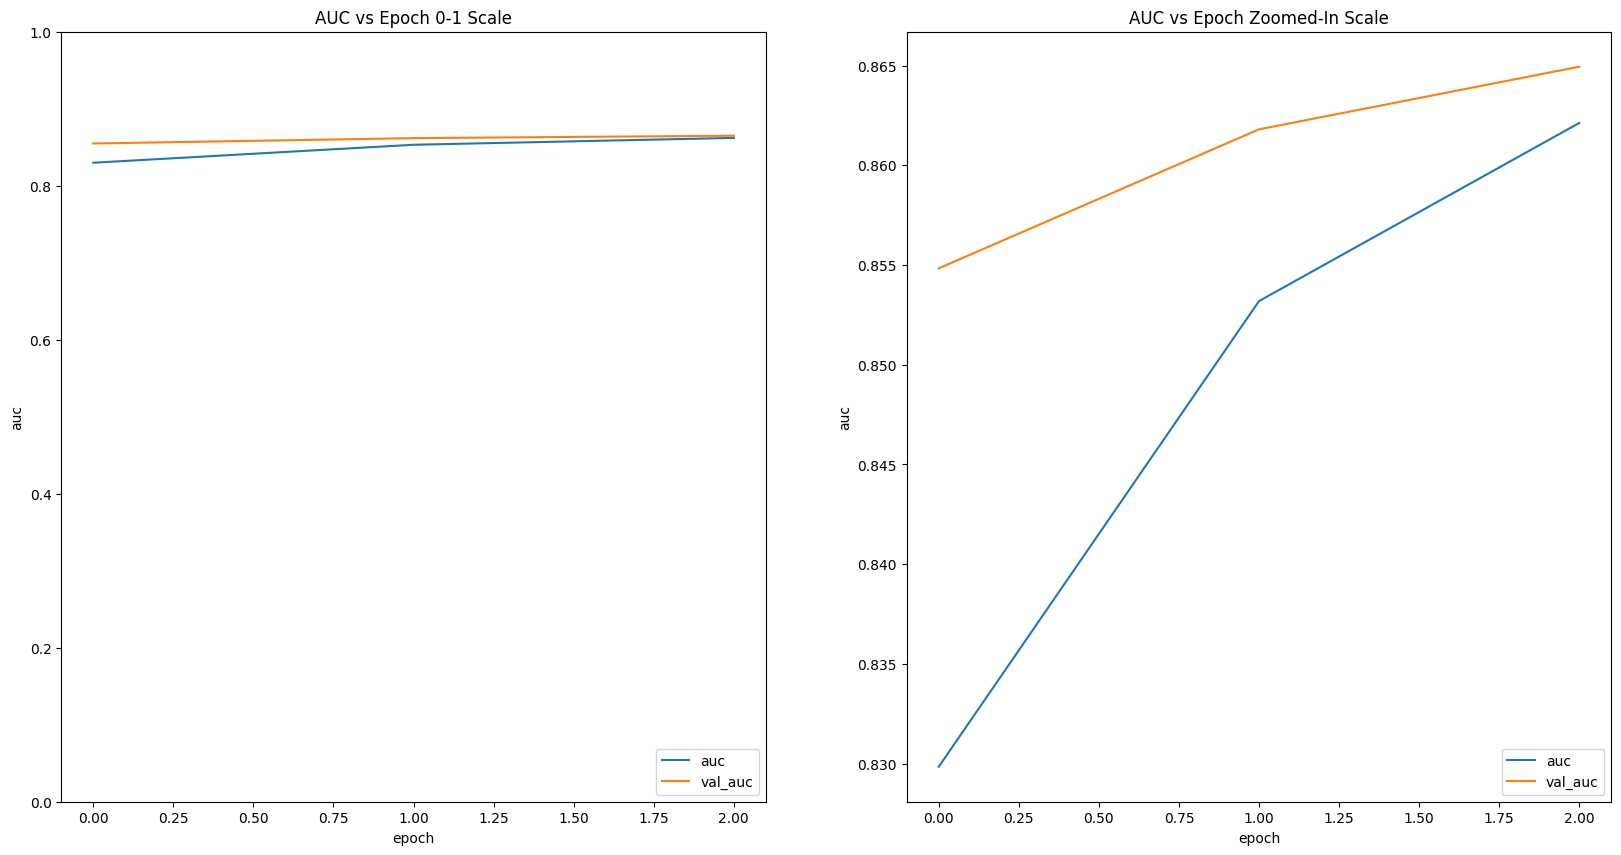

In [27]:
hist = cnn.fit(
    ds_train
    , epochs=epochs
    , validation_data=ds_val
)

gimme_plots(hist)

preds = cnn.predict(
    ds_test
    , verbose=2
)

# Gives AUC of private 0.7469 and public 0.7918
gimme_preds(preds, 'model_01')

### Model 02

In [22]:
cnn = models.Sequential()
cnn.add(Input((32, 32, 3)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

cnn.compile(
    optimizer=optimizer
    , loss=loss
    , metrics=[metric]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,449 (876.75 KB)

 Trainable params: 224,449 (876.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - auc: 0.8060 - loss: 0.5222 - val_auc: 0.8552 - val_loss: 0.4633
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - auc: 0.8499 - loss: 0.4684 - val_auc: 0.8697 - val_loss: 0.4436
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - auc: 0.8646 - loss: 0.4463 - val_auc: 0.8697 - val_loss: 0.4389
1796/1796 - 5s - 3ms/step


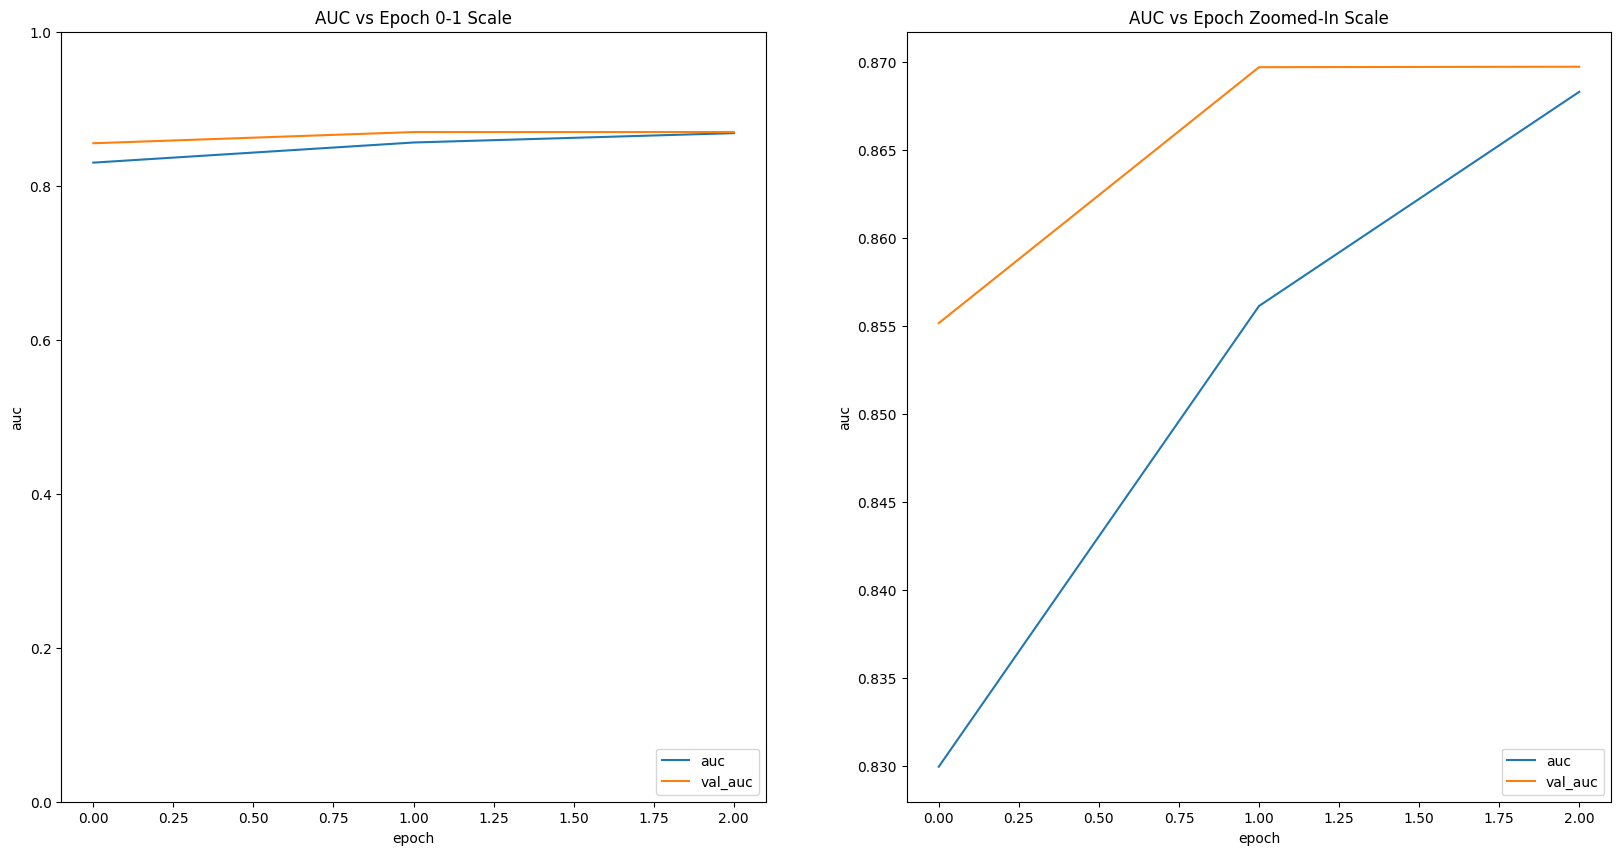

In [23]:
hist = cnn.fit(
    ds_train
    , epochs=epochs
    , validation_data=ds_val
)

gimme_plots(hist)

preds = cnn.predict(
    ds_test
    , verbose=2
)

# Gives AUC of private 0.7276 and public 0.7940
gimme_preds(preds, 'model_02')

### Model 03

In [28]:
cnn = models.Sequential()
cnn.add(Input((32, 32, 3)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

cnn.compile(
    optimizer=optimizer
    , loss=loss
    , metrics=[metric]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,737 (768.50 KB)

 Trainable params: 196,737 (768.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - auc: 0.5329 - loss: 0.6788 - val_auc: 0.5000 - val_loss: 0.6745
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.4980 - loss: 0.6753 - val_auc: 0.5000 - val_loss: 0.6745
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.4980 - loss: 0.6753 - val_auc: 0.5000 - val_loss: 0.6745
1796/1796 - 5s - 3ms/step


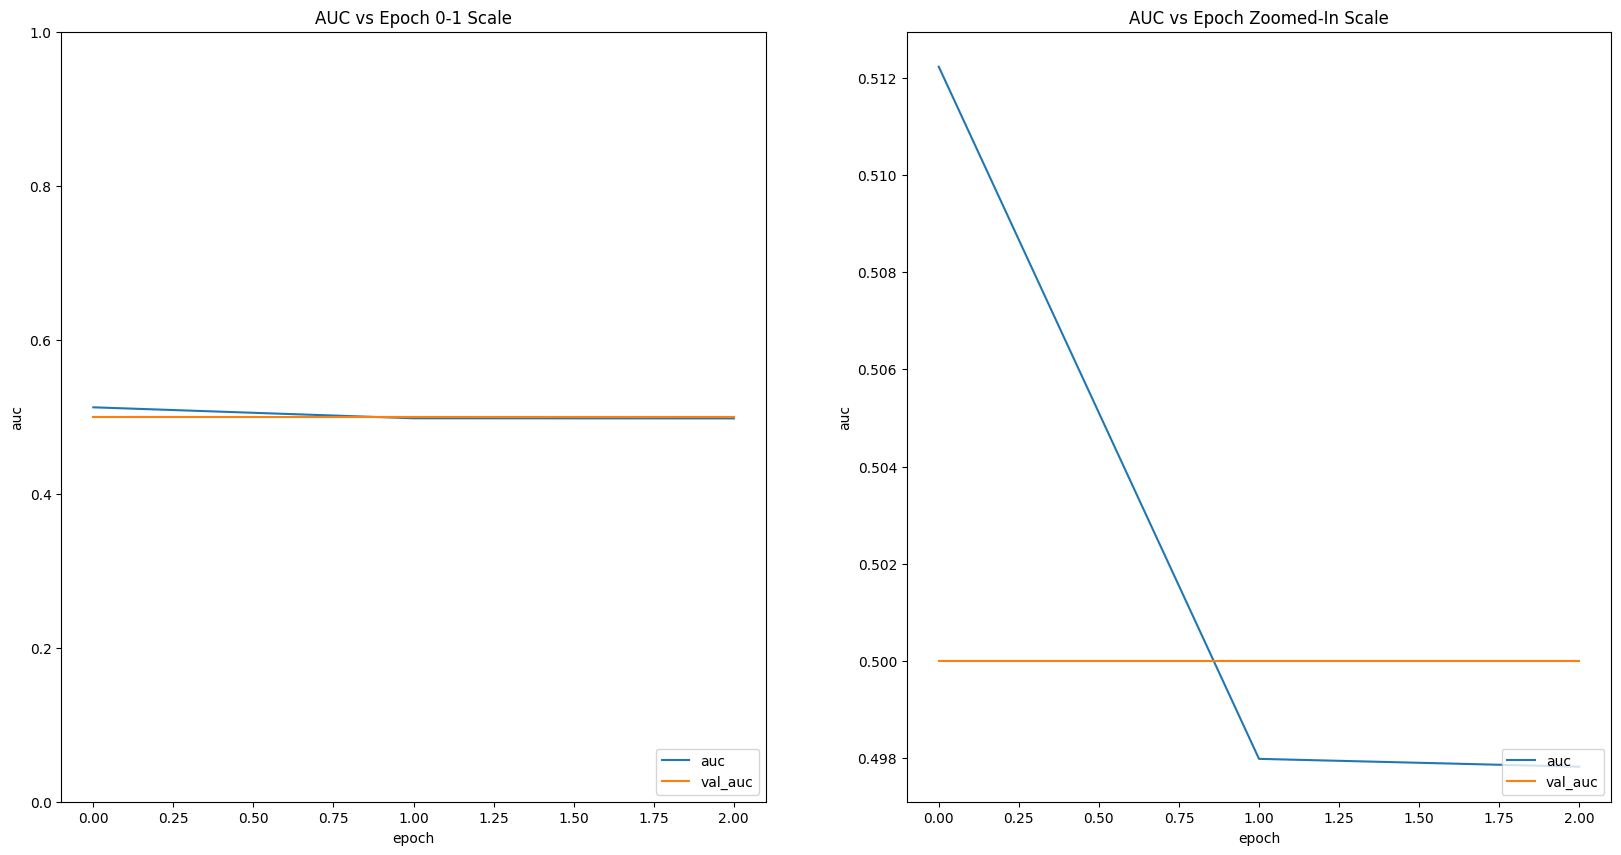

In [29]:
hist = cnn.fit(
    ds_train
    , epochs=epochs
    , validation_data=ds_val
)

gimme_plots(hist)

preds = cnn.predict(
    ds_test
    , verbose=2
)

# Gives AUC of private 0.500 and public 0.500
gimme_preds(preds, 'model_03')

### Model 04

In [30]:
cnn = models.Sequential()
cnn.add(Input((32, 32, 3)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

cnn.compile(
    optimizer=optimizer
    , loss=loss
    , metrics=[metric]
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,057 (801.00 KB)

 Trainable params: 205,057 (801.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - auc: 0.6775 - loss: 0.6254 - val_auc: 0.7636 - val_loss: 0.5865
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.7486 - loss: 0.5792 - val_auc: 0.7653 - val_loss: 0.6251
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.7573 - loss: 0.5719 - val_auc: 0.7674 - val_loss: 0.5944
1796/1796 - 5s - 3ms/step


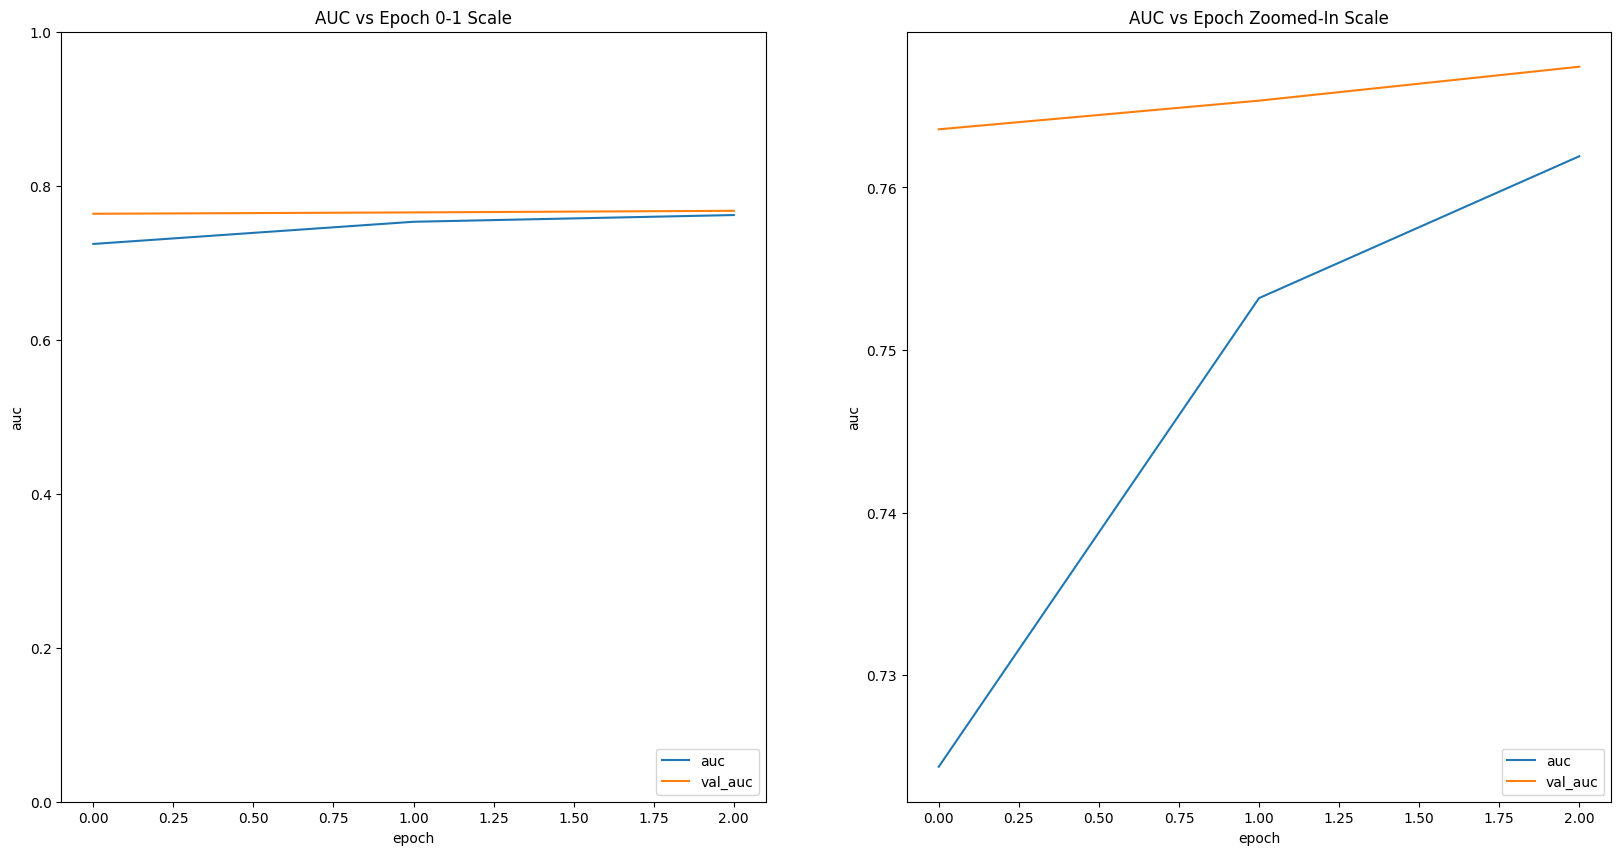

In [31]:
hist = cnn.fit(
    ds_train
    , epochs=epochs
    , validation_data=ds_val
)

gimme_plots(hist)

preds = cnn.predict(
    ds_test
    , verbose=2
)

# Gives AUC of private 0.6098 and public 0.7061
gimme_preds(preds, 'model_04')

### Model 05

### Model 06

### Model 07

### Model 08

### Model 09

## Modeling Results Summary

## Conclusion